# CNN for highway - primary detection

Adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import sklearn.metrics as metrics

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Hyperparameter Collection

In [2]:
batch_size = 10
learning_rate = .001

# Decay LR by a factor of lr_gamma every lr_step_size epochs
lr_step_size = 7
lr_gamma = 0.1

epochs = 20

# Not a hyperparameter, but it fits here :)
torch.manual_seed(1337)

## Data Preparation

1. Sort data into dirs by labels
2. Use torch ImageFolder to load data

In [3]:
path = os.path.join("huawei", "dataset")

In [4]:
# for ds in ["val", "train"]:
#     data_set = pd.read_csv(os.path.join(path, ds, "labels.csv"))
#     for _, row in data_set.iterrows():
#         os.rename(os.path.join(path, ds, f"{row['image_id']}.jpg"), os.path.join(path, ds, row['highway'], f"{row['image_id']}.jpg"))

In [5]:
train_set = torchvision.datasets.ImageFolder(
    os.path.join(path, "train"),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomPerspective(distortion_scale=0.4),
        transforms.RandomRotation(degrees=(-45, 45)),
        transforms.ToTensor(),
    ])
)
val_set = torchvision.datasets.ImageFolder(
    os.path.join(path, "val"),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
)
classes = train_set.classes
classes

['footway', 'primary']

In [6]:
class IssuesDataset(torch.utils.data.Dataset):

    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(os.path.join(img_dir, "issues.csv"))
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        id = self.img_labels.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, f"{id}.jpg")
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, id

In [7]:
test_set = IssuesDataset(
    os.path.join(path, "issues"),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
)

In [8]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

500
125
30


In [9]:
train_dl = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
val_dl = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_dl = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

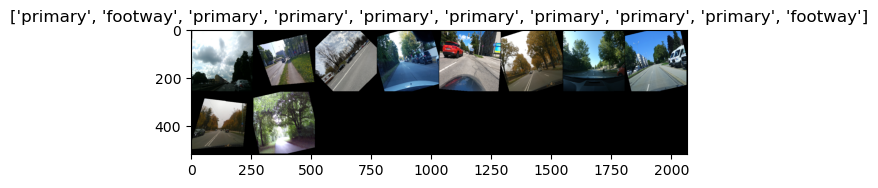

In [10]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, labels = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classes[x] for x in labels])

## Transfer Learning

In [11]:
model = models.resnet18(pretrained=True)
# freeze parameters of pretrained net
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))

criterion = nn.CrossEntropyLoss()

# optimize only params of new FC layer
optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=lr_step_size, gamma=lr_gamma)

## Training

In [12]:
def abs_acc(preds, labels):
    return torch.sum(torch.argmax(preds, dim=1) == labels)

def train(network, loader, loss_f, scheduler, batch_size, size, num_epochs):
    has_cuda = torch.cuda.is_available()

    if has_cuda:
        network = network.cuda()

    print(f'epochs={num_epochs} batch_size={batch_size} lr={learning_rate}')

    for epoch in range(num_epochs):
        total_loss = 0
        total_correct = 0

        for images, labels in loader:
            if has_cuda:
                images = images.cuda()
                labels = labels.cuda()

            preds = network(images)
            loss = loss_f(preds, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch_size
            total_correct += abs_acc(preds, labels)
        
        scheduler.step()
        print("epoch: ", epoch, ", total_correct: ", total_correct, ", loss: ", total_loss, ", %", total_correct / size * 100)

In [ ]:
model.train()
train(model, train_dl, criterion, exp_lr_scheduler, batch_size, len(train_set), epochs)

In [ ]:
# Save model parameters
torch.save(model.state_dict(), "./models/highway3.pth")

In [13]:
# Load the saved model
model.load_state_dict(torch.load("./models/highway1.pth"))

<All keys matched successfully>

In [14]:
all_preds = None
all_max_preds = None
all_labels = None

def test(network, loader, loss_f, batch_size, size):
    global all_preds
    global all_max_preds
    global all_labels

    wrong_preds = []

    total_correct = 0
    total_loss = 0

    has_cuda = torch.cuda.is_available()

    if has_cuda:
        network = network.cuda()

    for images, labels in loader:
        if has_cuda:
            images = images.cuda()
            labels = labels.cuda()
        
        preds = network(images)
        loss = loss_f(preds, labels)

        _, max_preds = torch.max(preds, 1)
        wrong_preds += zip(images[labels != max_preds], labels[labels != max_preds])

        total_loss += loss.item() * batch_size
        total_correct += abs_acc(preds, labels)
    
        all_preds = torch.cat((all_preds, preds.cpu()), dim=0) if all_preds is not None else preds.cpu()
        all_max_preds = torch.cat((all_max_preds, max_preds.cpu()), dim=0) if all_max_preds is not None else max_preds.cpu()
        all_labels = torch.cat((all_labels, labels.cpu()), dim=0) if all_labels is not None else labels.cpu()
    

    print("TEST -> total_correct: ", total_correct, ", loss: ", total_loss, ", %", total_correct / size * 100)
    return wrong_preds

In [15]:
all_preds = None
all_max_preds = None
all_labels = None

model.eval()
wrong_preds = test(model, val_dl, criterion, batch_size, len(val_set))

TEST -> total_correct:  tensor(114) , loss:  28.77465419471264 , % tensor(91.2000)


In [16]:
def show_images(img):
    for i, (image, label) in enumerate(img):
        ax = plt.subplot(int(np.ceil(len(img) / 2)), 2, i + 1)
        ax.axis('off')
        ax.set_title(f'actual: {classes[label.cpu()]}')
        imshow(image.cpu())

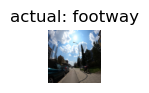

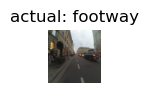

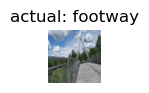

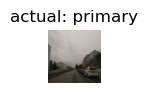

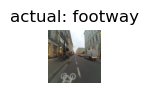

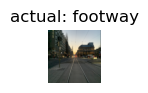

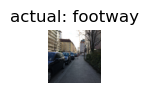

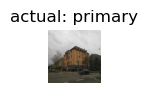

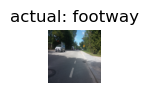

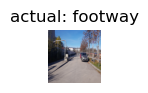

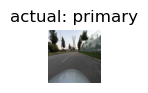

In [17]:
show_images(wrong_preds)

In [18]:
# Precsion & Recall
all_max_preds_d = None
all_labels_d = None

def print_stats():
    precision = metrics.precision_score(all_labels_d, all_max_preds_d, pos_label=1)
    recall = metrics.recall_score(all_labels_d, all_max_preds_d, pos_label=1)
    print(f"Precision: {precision}, Recall: {recall} (positive class: {classes[1]})")

    precision = metrics.precision_score(all_labels_d, all_max_preds_d, pos_label=0)
    recall = metrics.recall_score(all_labels_d, all_max_preds_d, pos_label=0)
    print(f"Precision: {precision}, Recall: {recall} (positive class: {classes[0]})")

    accuracy = metrics.accuracy_score(all_labels_d, all_max_preds_d)
    print(f"Accuracy: {accuracy}")

In [19]:
all_max_preds_d = all_max_preds.detach().numpy()
all_labels_d = all_labels.detach().numpy()
print_stats()

Precision: 0.8805970149253731, Recall: 0.9516129032258065 (positive class: primary)
Precision: 0.9482758620689655, Recall: 0.873015873015873 (positive class: footway)
Accuracy: 0.912


In [20]:
def visualize_model(network, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        has_cuda = torch.cuda.is_available()

        if has_cuda:
            network = network.cuda()
        
        for images, labels in val_dl:
            if has_cuda:
                images = images.cuda()
                labels = labels.cuda()

            outputs = network(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size()[0]):
                images_so_far += 1
                if images_so_far > num_images:
                    break
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'p: {classes[preds[j]]}, a: {classes[labels[j]]}')
                imshow(inputs.cpu().data[j])

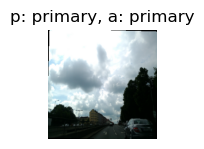

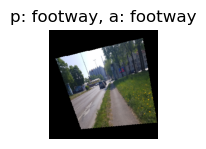

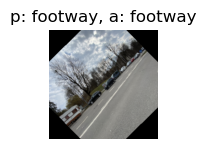

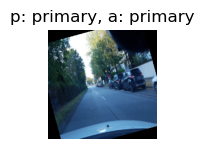

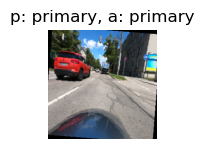

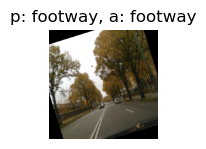

In [21]:
visualize_model(model)
plt.ioff()
plt.show()

In [22]:
def predict(network, dl):
    all_preds = None
    all_labels = None
    with torch.no_grad():
        all_preds = None
        has_cuda = torch.cuda.is_available()

        if has_cuda:
            network = network.cuda()
        
        for images, labels in dl:
            if has_cuda:
                images = images.cuda()

            outputs = network(images)
            _, preds = torch.max(outputs, 1)
            all_preds = torch.cat((all_preds, preds.cpu()), dim=0) if all_preds is not None else preds.cpu()
            all_labels = torch.cat((all_labels, labels), dim=0) if all_labels is not None else labels
        return all_preds, all_labels

In [23]:
model.eval()
preds, img_ids = predict(model, test_dl)
for id, pred in zip(img_ids, preds):
    print(f"{id}: {classes[pred]}")

173529288004582: primary
187098909929555: footway
216283226982432: footway
269290068323331: footway
305399287917735: footway
308707770748550: footway
310698823750341: primary
315970676772352: footway
334213504878448: primary
387616345626796: footway
432081875138552: footway
486527229463839: primary
497792407930066: primary
507005454009469: footway
518223702859508: primary
532051091386866: primary
568493717757567: footway
677806630089122: footway
742794133052728: primary
796584247628919: footway
811604529752448: primary
821061125222211: primary
824423578448957: footway
827676088105008: footway
877953149735095: primary
927816371125415: primary
952367918873603: footway
1998769373606723: primary
2096254440714769: footway
2947015848899610: primary


In [43]:
def write_highway_csv(img_ids, preds, filename="output.csv"):
    d = {
        "Image_id": np.array(img_ids),
        "highway": np.array(classes[pred] for pred in preds),
    }
    df = pd.DataFrame(data=d)
    df.to_csv(os.path.join("results", filename), index=False)

In [24]:
write_highway_csv(img_ids, preds)

## Extra issues

In [25]:
extra = IssuesDataset(
    os.path.join(path, "extra_issues"),
    transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ]),
)
extra_dl = torch.utils.data.DataLoader(extra, batch_size=batch_size, shuffle=False, num_workers=0)

In [45]:
model.eval()
preds, img_ids = predict(model, extra_dl)
write_highway_csv(img_ids, preds, filename="extra_output.csv")